# Sex-Specific Alzheimer's Disease Modelling Experimentations

## Set-up and Cleaning

In [4]:
# === Load and clean data ===
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from scipy import stats
import random


In [5]:
# set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [6]:
# Load OASIS dataset
df = pd.read_csv("oasis_longitudinal.csv")
print(df)

    Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  \
0    OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87   
1    OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88   
2    OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75   
3    OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76   
4    OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80   
..         ...            ...          ...    ...       ...  ..  ...  ...   
368  OAS2_0185  OAS2_0185_MR2     Demented      2       842   M    R   82   
369  OAS2_0185  OAS2_0185_MR3     Demented      3      2297   M    R   86   
370  OAS2_0186  OAS2_0186_MR1  Nondemented      1         0   F    R   61   
371  OAS2_0186  OAS2_0186_MR2  Nondemented      2       763   F    R   63   
372  OAS2_0186  OAS2_0186_MR3  Nondemented      3      1608   F    R   65   

     EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
0      14  2.0  27.0  0.0  

In [7]:
# Fill missing SES and MMSE values
df['SES'] = df['SES'].fillna(df['SES'].median())
df['MMSE'] = df['MMSE'].fillna(df['MMSE'].mean())

In [8]:
# Convert labels to binary classification: demented = 1, nondemented = 0
df['Group'] = df['Group'].replace("Converted", "Demented")
df['Group'] = df['Group'].map({"Demented": 1, "Nondemented": 0})

In [9]:
# Define features and dropping missing values
my_features = ['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
df_clean = df.dropna(subset=my_features + ['Group', 'M/F'])

## Repeated Train/Test Evaluation Function

In [11]:

# === REPEATED TRAIN/TEST EVALUATION ===

def repeated_evaluation(model, X, y, label, splits, sex=None, sex_filter=None):
    fold_metrics = []
    for repeat, fold, train_idx, test_idx in splits:
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            if len(train_idx) == 0 or len(test_idx) == 0:
                continue
            scaler = StandardScaler() 
            X_train_scaled = scaler.fit_transform(X_train) 
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
            if sex is not None and sex_filter is not None:
                test_sex = sex.iloc[test_idx]
                mask = test_sex == sex_filter
                if not mask.any():
                    continue
                y_test = y_test[mask]
                y_pred = y_pred[mask]
                y_proba = y_proba[mask]

            fold_metrics.append({
                'repeat': repeat,
                'fold': fold,
                'accuracy': accuracy_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_proba)
            })

    metrics_df = pd.DataFrame(fold_metrics)
    metrics = metrics_df[['accuracy', 'f1', 'precision', 'recall', 'roc_auc']]
    means = metrics.mean()
    stds = metrics.std()
    summary = [
        label,
        means['accuracy'], stds['accuracy'],
        means['f1'], stds['f1'],
        means['precision'], stds['precision'],
        means['recall'], stds['recall'],
        means['roc_auc'], stds['roc_auc']
    ]
   
    return summary, metrics_df

In [12]:

X_all = df_clean[my_features]
y_all = df_clean['Group']
sex_all = df_clean['M/F']
groups_all = df_clean['Subject ID']

In [13]:
# Compute cross-validation splits
splits_all = []
for repeat in range(5):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42 + repeat)
    for fold, (train_idx, test_idx) in enumerate(sgkf.split(X_all, y_all, groups_all)):
        splits_all.append((repeat, fold, train_idx, test_idx))
male_idx = np.where(sex_all == 'M')[0]
female_idx = np.where(sex_all == 'F')[0]
splits_m, splits_f = [], []
for repeat, fold, train_idx, test_idx in splits_all:
    m_train = np.intersect1d(train_idx, male_idx)
    m_test = np.intersect1d(test_idx, male_idx)
    if len(m_train) and len(m_test):
        splits_m.append((repeat, fold, m_train, m_test))
    f_train = np.intersect1d(train_idx, female_idx)
    f_test = np.intersect1d(test_idx, female_idx)
    if len(f_train) and len(f_test):
        splits_f.append((repeat, fold, f_train, f_test))

## Logistic Regression and Random Forest Classifier Models

In [15]:

# === General models ===
LR_RF_results = []
results_folds = {}

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-All", splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-All"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED), X_all, y_all, "Gen-RF-All", splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-All"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-M", sex=sex_all, sex_filter='M', splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-M"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-F", sex=sex_all, sex_filter='F', splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-F"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED), X_all, y_all, "Gen-RF-M", sex=sex_all, sex_filter='M', splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-M"] = folds
summary, fold = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED), X_all, y_all, "Gen-RF-F", sex=sex_all, sex_filter='F', splits=splits_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-F"] = folds


In [16]:

# === Sex specific models ===

df_male = df_clean[df_clean['M/F'] == 'M']
df_female = df_clean[df_clean['M/F'] == 'F']
groups_f = df_female['Subject ID']
groups_m = df_male['Subject ID']

X_m, y_m = df_male[my_features], df_male['Group']

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Male-LR-M", splits=splits_m)
LR_RF_results.append(summary)
results_folds["Male-LR-M"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED), X_all, y_all, "Male-RF-M", splits=splits_m)
LR_RF_results.append(summary)
results_folds["Male-RF-M"] = folds

X_f, y_f = df_female[my_features], df_female['Group']

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Female-LR-F", splits=splits_f)
LR_RF_results.append(summary)
results_folds["Female-LR-F"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED), X_all, y_all, "Female-RF-F", splits=splits_f)
LR_RF_results.append(summary)
results_folds["Female-RF-F"] = folds



In [17]:

# === Results Table ===
columns =['Model', 'Accuracy_mean', 'Accuracy_std', 'F1_mean', 'F1_std', 'Precision_mean', 'Precision_std', 'Recall_mean', 'Recall_std', 'AUC_mean', 'AUC_std']
results_table = pd.DataFrame(LR_RF_results, columns=columns)
n_splits, n_repeats = 5, 15
metrics = ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']
N = n_splits * n_repeats
for metric in metrics:
    se = results_table[f'{metric}_std'] / np.sqrt(N)
    results_table[f'{metric}_ci_lower'] = results_table[f'{metric}_mean'] - 1.96 * se
    results_table[f'{metric}_ci_upper'] = results_table[f'{metric}_mean'] + 1.96 * se
print(results_table)


         Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std  \
0   Gen-LR-All       0.945927      0.021990  0.941873  0.021347   
1   Gen-RF-All       0.936700      0.032105  0.931621  0.035378   
2     Gen-LR-M       0.956230      0.034544  0.961849  0.031498   
3     Gen-LR-F       0.936758      0.036278  0.910120  0.055254   
4     Gen-RF-M       0.942454      0.041098  0.949057  0.036740   
5     Gen-RF-F       0.930820      0.041843  0.904647  0.056916   
6    Male-LR-M       0.932801      0.047855  0.941322  0.041442   
7    Male-RF-M       0.892849      0.089267  0.906683  0.087400   
8  Female-LR-F       0.939175      0.039311  0.915039  0.054250   
9  Female-RF-F       0.924499      0.048661  0.896839  0.062320   

   Precision_mean  Precision_std  Recall_mean  Recall_std  AUC_mean  ...  \
0        0.985003       0.016447     0.902982    0.034289  0.965200  ...   
1        0.965845       0.044896     0.901622    0.046121  0.954898  ...   
2        0.977290       0.032631  

## XGBOOST models

In [19]:
xgb_results = []
xgb_fold_results = {}
xgb_model = XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED)

summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-All', splits=splits_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-All'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-M', sex=sex_all, sex_filter='M', splits=splits_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-F', sex=sex_all, sex_filter='F', splits=splits_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-F'] = folds

summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Male-XGB-M', splits=splits_m)
xgb_results.append(summary)                  
xgb_fold_results['Male-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Female-XGB-F', splits=splits_f)
xgb_results.append(summary)                  
xgb_fold_results['Female-XGB-F'] = folds



In [20]:
xgb_results_table = pd.DataFrame(xgb_results, columns=columns)
n_splits, n_repeats = 5, 15
N = n_splits * n_repeats
for metric in metrics:
    se = xgb_results_table[f'{metric}_std'] / np.sqrt(N)
    xgb_results_table[f'{metric}_ci_lower'] = xgb_results_table[f'{metric}_mean'] - 1.96 * se
    xgb_results_table[f'{metric}_ci_upper'] = xgb_results_table[f'{metric}_mean'] + 1.96 * se
print(xgb_results_table)

          Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std  \
0   Gen-XGB-All       0.924207      0.032219  0.918348  0.038928   
1     Gen-XGB-M       0.932946      0.040311  0.940016  0.043949   
2     Gen-XGB-F       0.916102      0.051078  0.883848  0.079170   
3    Male-XGB-M       0.931441      0.055527  0.940586  0.056575   
4  Female-XGB-F       0.908645      0.053237  0.874307  0.077268   

   Precision_mean  Precision_std  Recall_mean  Recall_std  AUC_mean  ...  \
0        0.931866       0.060328     0.907490    0.038961  0.949534  ...   
1        0.936216       0.072513     0.949365    0.056374  0.973698  ...   
2        0.921859       0.094487     0.855436    0.092823  0.923756  ...   
3        0.934288       0.093433     0.955354    0.050944  0.971787  ...   
4        0.913072       0.102838     0.846570    0.090464  0.931542  ...   

   Accuracy_ci_lower  Accuracy_ci_upper  F1_ci_lower  F1_ci_upper  \
0           0.916915           0.931499     0.909538     0.927158

## Support Vector Machine and Voting Classifier Models 

In [22]:
svm_vote_results = []
svm_vote_fold_results = {}
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_SEED)

# === SVM general models ===
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-All', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-All'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-M', sex=sex_all, sex_filter='M', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-M'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-F', sex=sex_all, sex_filter='F', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-F'] = folds

# === SVM sex-specific models ===
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Male-SVM-M', splits=splits_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-SVM-M'] = folds

summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Female-SVM-F', splits=splits_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-SVM-F'] = folds

In [23]:
# === Voting Classifier Set-up ===

voting_estimators =[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_SEED)),
]
voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')

    

In [24]:
# === VC general models ===
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VOTE-All', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VOTE-All'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VOTE-M', sex=sex_all, sex_filter='M', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VOTE-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VOTE-F', sex=sex_all, sex_filter='F', splits=splits_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VOTE-F'] = folds
                                         
# === VC sex-specific models
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Male-VOTE-M',  splits=splits_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-VOTE-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Female-VOTE-F', splits=splits_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-VOTE-F'] = folds


In [25]:
# === SVM and VC results ===

svm_vote_results_table = pd.DataFrame(svm_vote_results, columns=columns)
n_splits, n_repeats = 5, 15
N = n_splits * n_repeats
for metric in metrics:
    se = svm_vote_results_table[f'{metric}_std'] / np.sqrt(N)
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] - 1.96 * se
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] + 1.96 * se
print(svm_vote_results_table)

           Model  Accuracy_mean  Accuracy_std   F1_mean    F1_std  \
0    Gen-SVM-All       0.943812      0.023695  0.939531  0.024260   
1      Gen-SVM-M       0.955054      0.034536  0.961033  0.031261   
2      Gen-SVM-F       0.933638      0.040322  0.907225  0.058327   
3     Male-SVM-M       0.934329      0.052239  0.939880  0.060057   
4   Female-SVM-F       0.929825      0.048181  0.903188  0.061905   
5   Gen-VOTE-All       0.946460      0.022453  0.942504  0.022020   
6     Gen-VOTE-M       0.956230      0.034544  0.961849  0.031498   
7     Gen-VOTE-F       0.937446      0.035808  0.911506  0.053398   
8    Male-VOTE-M       0.926904      0.064754  0.932982  0.072988   
9  Female-VOTE-F       0.932623      0.044831  0.906537  0.060104   

   Precision_mean  Precision_std  Recall_mean  Recall_std  AUC_mean   AUC_std  \
0        0.982592       0.024459     0.900845    0.035707  0.942918  0.025436   
1        0.977229       0.032664     0.947765    0.055437  0.956343  0.050652 

## Visually Assessing Model Accuracies - Initial Look

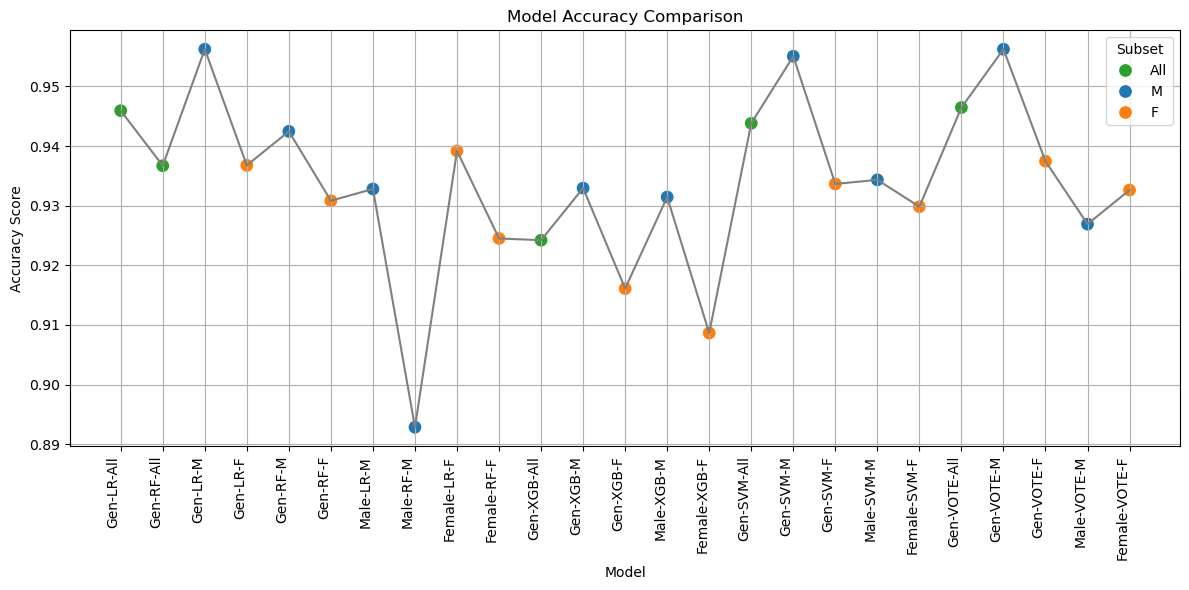

In [27]:
all_results_table = pd.concat([results_table, xgb_results_table, svm_vote_results_table], ignore_index=True)
all_results_table['Subset'] = all_results_table['Model'].str.split('-').str[-1]
palette = {'F': 'tab:orange', 'M': 'tab:blue', 'All': 'tab:green'}
plt.figure(figsize=(12,6))
plt.plot(all_results_table['Model'], all_results_table['Accuracy_mean'], color='gray')
sns.scatterplot(data=all_results_table, x='Model', y='Accuracy_mean', hue='Subset', palette=palette, s=100)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Subset')
plt.show()

## t-tests

In [29]:
from statistics import mean, stdev, NormalDist, StatisticsError
from math import sqrt

from statistics import mean, stdev, NormalDist, StatisticsError
from math import sqrt


In [30]:
# Use paired t-tests to compare model performance on per-fold metrics
import pandas as pd
from itertools import combinations
metric = "roc_auc"
all_fold_tables = []
for results in (results_folds, xgb_fold_results, svm_vote_fold_results):
    for model_name, fold_df in results.items():
        df = fold_df.copy()
        df["model"] = model_name
        all_fold_tables.append(df)

fold_metrics = pd.concat(all_fold_tables, ignore_index=True)
parts = fold_metrics["model"].str.split("-", expand=True)
fold_metrics["selection"] = parts[0]
fold_metrics["algorithm"] = parts[1]
fold_metrics["sex"] = parts[2]


#p_value = ttest_rel(baseline_fold_metrics, sex_specific_fold_metrics).pvalue

In [31]:
# collect p-values for Holm-Bonferroni correction

p_values = []
comparisons = []

for alg in fold_metrics["algorithm"].unique():
    for sex in ["M", "F"]:
        baseline_df = fold_metrics[
            (fold_metrics["selection"] == "Gen") &
            (fold_metrics["algorithm"] == alg) &
            (fold_metrics["sex"] == sex)
        ][["repeat", "fold", metric]]
        specific_group = "Male" if sex == "M" else "Female"
        specific_df = fold_metrics[
            (fold_metrics["selection"] == specific_group) &
            (fold_metrics["algorithm"] == alg) &
            (fold_metrics["sex"] == sex)
        ][["repeat", "fold", metric]]
        merged = baseline_df.merge(specific_df, on=["repeat", "fold"], suffixes=("_base", "_spec"))
        if not merged.empty:
            p_value = ttest_rel(merged[f"{metric}_base"], merged[f"{metric}_spec"]).pvalue
            print(f"{alg}-{sex}: p-value={p_value:.4f}")



LR-M: p-value=0.8329
LR-F: p-value=0.0437
RF-M: p-value=0.0930
RF-F: p-value=0.0026
XGB-M: p-value=0.6001
XGB-F: p-value=0.1605
SVM-M: p-value=0.0326
SVM-F: p-value=0.5522
VOTE-M: p-value=0.0687
VOTE-F: p-value=0.4512


In [32]:
#### TODO
#from scipy.stats import ttest_rel
#import pandas as pd

# Extract AUC scores for each model from the earlier results
# Define model pairs to compare
# Perform t-tests
# Bonferroni correction

# Evaluate all models with cross validation??